# Exploratory Data Analysis

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1320210409)
randomstate = np.random.RandomState(1320210409)

# The data

## Features

All features are hourly and a country-wide average.
- **Time** _[YYYY-MM-DD HH:MM:SS]_
- **el_load:** electricity load _[MW]_
- **prec:** rainfall amount _[mm]_
- **temp:** temperature _[°C]_
- **rhum:** relative humidity [%]
- **grad:** global radiation _[J/cm²]_
- **pres:** momentary sea level air pressure _[hPa]_
- **wind:** average wind speed _[m/s]_
- **Vel_tviz:** Velence water temperature in Agárd _[°C]_
- **Bal_tviz:** Balaton water temperature in Siófok _[°C]_
- **holiday:** 1 or 0 depending on if it's a holiday
- **weekend:** 1 or 0 depending on if it's a weekend
- **covid:** 1 or 0 depending on covid restrictions in Hungary (estimate)

### The goal

I want to predict Hungary's electricity load for the **next couple hours** using this dataset, or it's differently aggregated counterpart (country, region, county or station)

In [2]:
df = pd.read_csv(
    'data/final_dataframe.csv',
    parse_dates=['Time'],
    index_col='Time',
    sep=';'
)

df.info()

df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75960 entries, 2015-01-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   el_load   75960 non-null  float64
 1   prec      75960 non-null  float64
 2   temp      75960 non-null  float64
 3   rhum      75960 non-null  float64
 4   grad      75960 non-null  float64
 5   pres      75960 non-null  float64
 6   wind      75960 non-null  float64
 7   Vel_tviz  75960 non-null  float64
 8   Bal_tviz  75960 non-null  float64
 9   holiday   75960 non-null  float64
 10  weekend   75960 non-null  float64
 11  covid     75960 non-null  float64
dtypes: float64(12)
memory usage: 7.5 MB


,el_load,prec,temp,rhum,grad,pres,wind,Vel_tviz,Bal_tviz,holiday,weekend,covid
Time,,,,,,,,,,,,
2015-01-01 00:00:00,4270.718,0.000000,-9.251456,75.980392,0.0,1038.024324,1.323232,-0.1,-0.1,1.0,0.0,0.0
2015-01-01 01:00:00,4068.940,0.000000,-8.543689,75.176471,0.0,1037.854054,1.480808,-0.1,-0.1,1.0,0.0,0.0
2015-01-01 02:00:00,3754.788,0.000000,-7.906796,73.970588,0.0,1037.551351,1.645455,-0.1,-0.1,1.0,0.0,0.0
2015-01-01 03:00:00,3510.361,0.000000,-7.561165,73.500000,0.0,1037.243243,1.768687,-0.1,-0.1,1.0,0.0,0.0
2015-01-01 04:00:00,3426.489,0.000000,-7.304854,72.921569,0.0,1036.662162,1.804040,-0.2,-0.2,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 19:00:00,5480.864,0.020588,17.266990,78.184466,0.0,1016.217949,1.331683,23.5,23.9,0.0,0.0,0.0
2023-08-31 20:00:00,5139.191,0.037255,16.307767,81.932039,0.0,1016.612821,1.282178,23.2,23.9,0.0,0.0,0.0
2023-08-31 21:00:00,4849.395,0.000980,15.510680,84.485437,0.0,1016.953846,1.212871,23.1,23.8,0.0,0.0,0.0


No null entries, I have dealt with those in the _data_organization_ notebook.

In [3]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['dayofmonth'] = df.index.day
df['dayofyear'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year

df

,el_load,prec,temp,rhum,grad,pres,wind,Vel_tviz,Bal_tviz,holiday,weekend,covid,hour,weekday,dayofmonth,dayofyear,month,year
Time,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,4270.718,0.000000,-9.251456,75.980392,0.0,1038.024324,1.323232,-0.1,-0.1,1.0,0.0,0.0,0,3,1,1,1,2015
2015-01-01 01:00:00,4068.940,0.000000,-8.543689,75.176471,0.0,1037.854054,1.480808,-0.1,-0.1,1.0,0.0,0.0,1,3,1,1,1,2015
2015-01-01 02:00:00,3754.788,0.000000,-7.906796,73.970588,0.0,1037.551351,1.645455,-0.1,-0.1,1.0,0.0,0.0,2,3,1,1,1,2015
2015-01-01 03:00:00,3510.361,0.000000,-7.561165,73.500000,0.0,1037.243243,1.768687,-0.1,-0.1,1.0,0.0,0.0,3,3,1,1,1,2015
2015-01-01 04:00:00,3426.489,0.000000,-7.304854,72.921569,0.0,1036.662162,1.804040,-0.2,-0.2,1.0,0.0,0.0,4,3,1,1,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 19:00:00,5480.864,0.020588,17.266990,78.184466,0.0,1016.217949,1.331683,23.5,23.9,0.0,0.0,0.0,19,3,31,243,8,2023
2023-08-31 20:00:00,5139.191,0.037255,16.307767,81.932039,0.0,1016.612821,1.282178,23.2,23.9,0.0,0.0,0.0,20,3,31,243,8,2023
2023-08-31 21:00:00,4849.395,0.000980,15.510680,84.485437,0.0,1016.953846,1.212871,23.1,23.8,0.0,0.0,0.0,21,3,31,243,8,2023


# Eploring the el_load feature

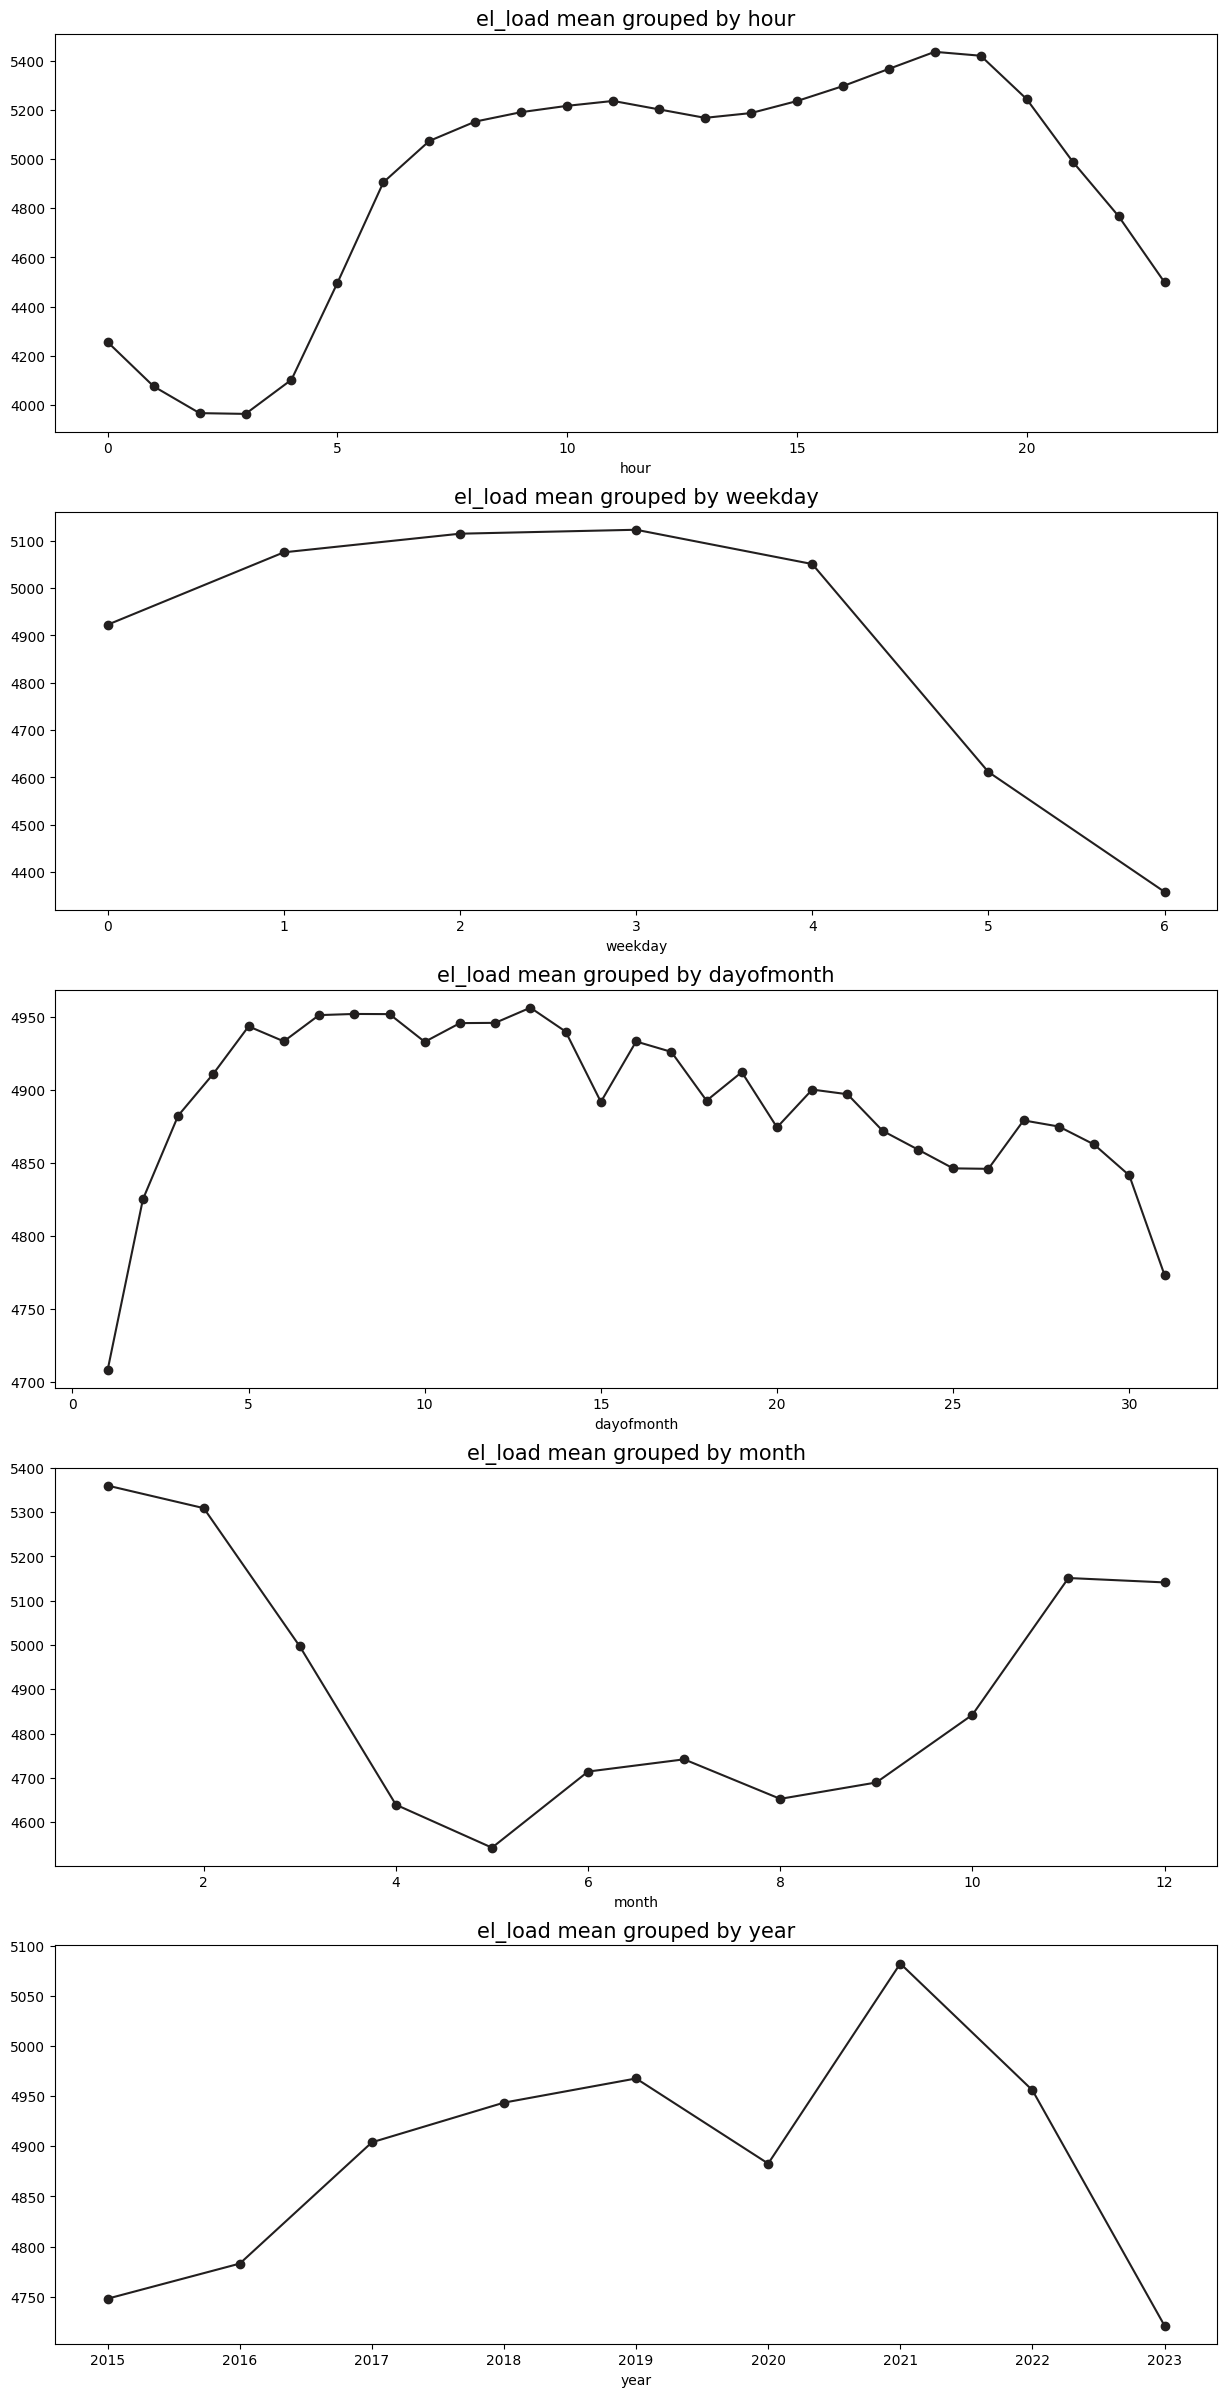

In [4]:
group_by = ['hour', 'weekday', 'dayofmonth', 'month', 'year']

fig, ax = plt.subplots(len(group_by), 1, figsize=(15, 30))

for group, ax in zip(group_by, ax.flatten()):
    grouped = df.groupby(group)['el_load'].mean()
    ax.set_title(f"el_load mean grouped by {group}", fontsize=15)
    grouped.plot(ax=ax, color="#221f1f", marker="o")

#### el_load
- daily averages rises during the day, it hits its at 18-19
- lower during the weekend
- we don't learn too much from the day of the month at this time
- during the year, load is higher in winter, probably since there's less sunlight
- we can see the effects of covid between 2020-2022

- **Time** _[YYYY-MM-DD HH:MM:SS]_
- **el_load:** electricity load _[MW]_
- **prec:** rainfall amount _[mm]_
- **temp:** temperature _[°C]_
- **rhum:** relative humidity [%]
- **grad:** global radiation _[J/cm²]_
- **pres:** momentary sea level air pressure _[hPa]_
- **wind:** average wind speed _[m/s]_
- **Vel_tviz:** Velence water temperature in Agárd _[°C]_
- **Bal_tviz:** Balaton water temperature in Siófok _[°C]_
- **holiday:** 1 or 0 depending on if it's a holiday
- **weekend:** 1 or 0 depending on if it's a weekend
- **covid:** 1 or 0 depending on covid restrictions in Hungary (estimate)

In [5]:
group_by = ['hour', 'weekday', 'dayofmonth', 'dayofyear', 'month', 'year']

def plot_feature(df: pd.DataFrame, groupes: list, feature: str, desc: str, color: str):
    group_len = len(groupes)
    fig, ax = plt.subplots(2, group_len // 2, figsize=(20, 7))
    fig.suptitle(f"Feature: {feature} ({desc})")
    for i, ax in enumerate(ax.flatten()):
        group = groupes[i % group_len]
        grouped = df.groupby(group)[feature].mean()
        ax.set_title(f"Grouped by {group}", fontsize=10)
        ax.plot(grouped, color=color)

#### Precipitation

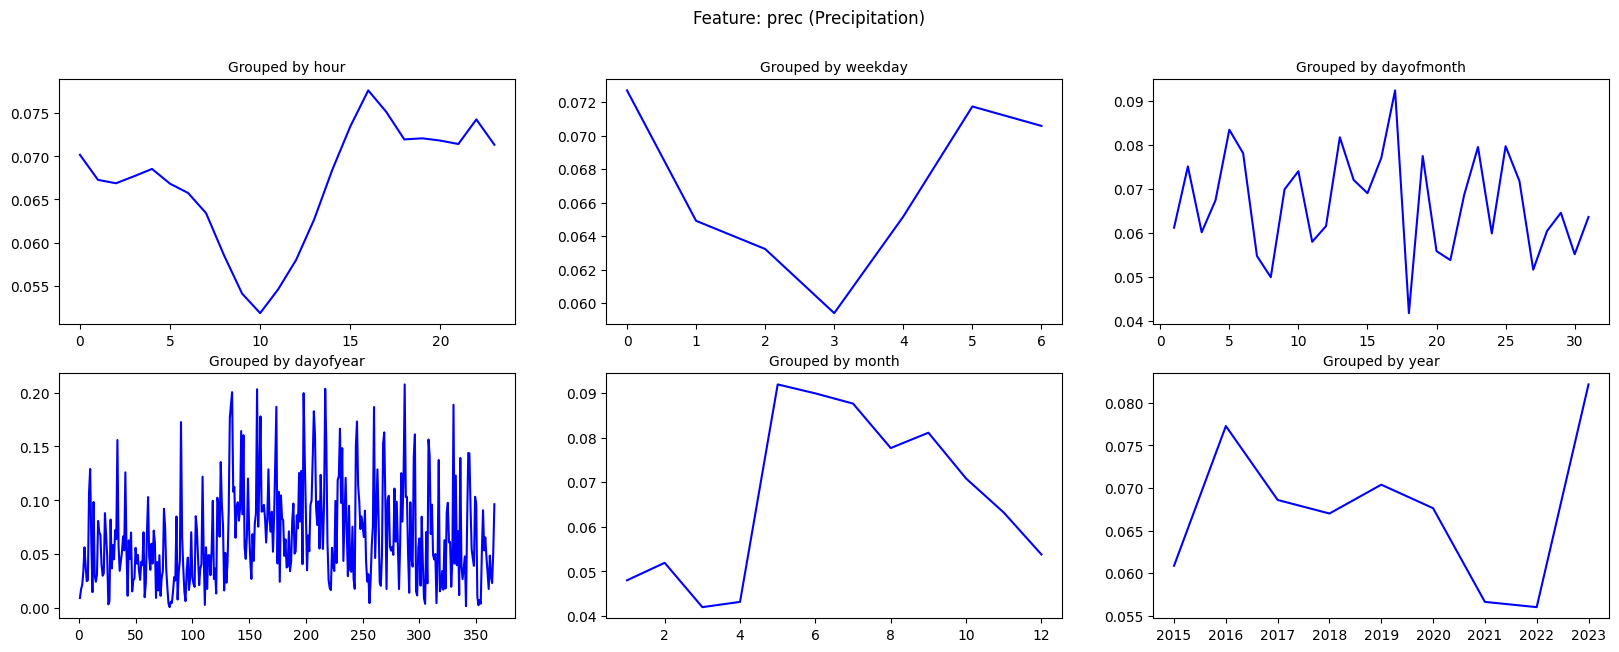

In [6]:
plot_feature(df, group_by, 'prec', 'Precipitation', 'blue')

#### Temperature

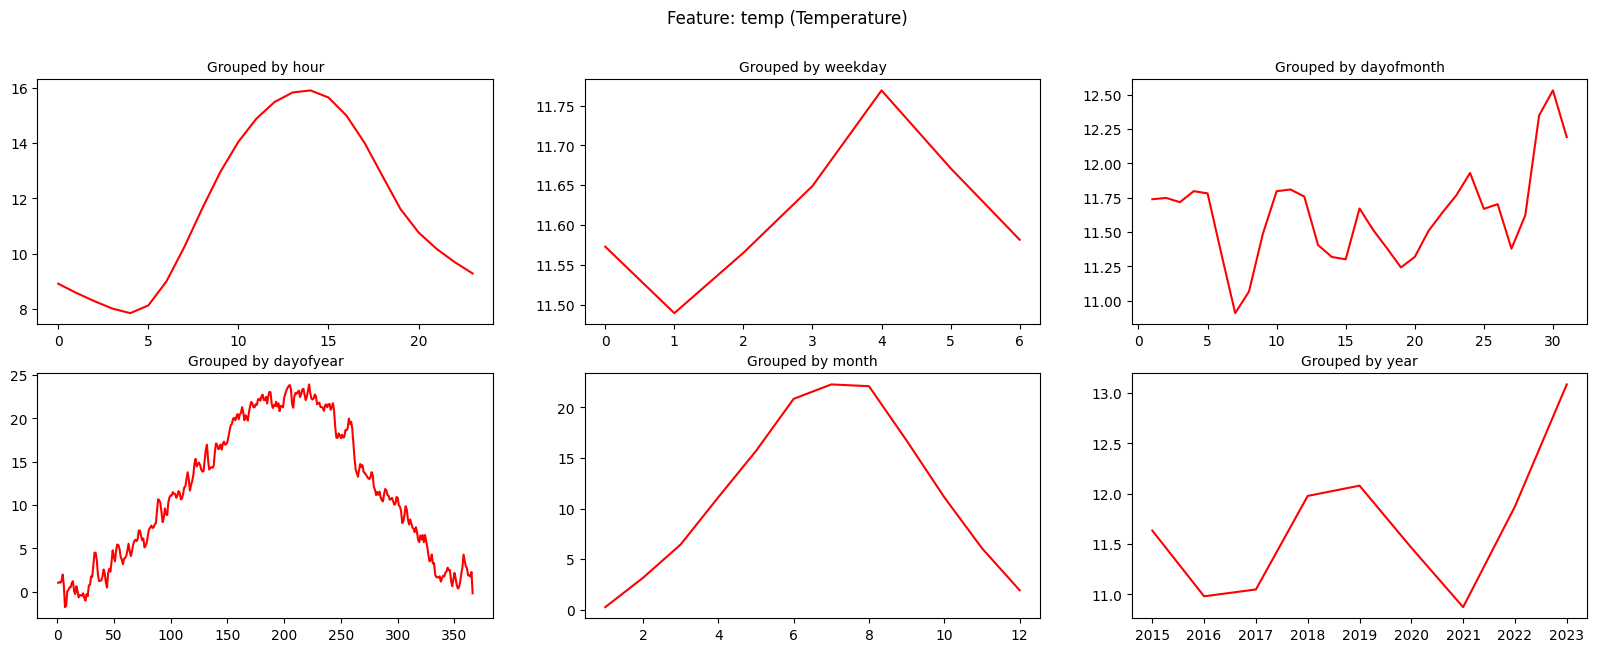

In [7]:
plot_feature(df, group_by, 'temp', 'Temperature', 'red')

#### Relative humidity

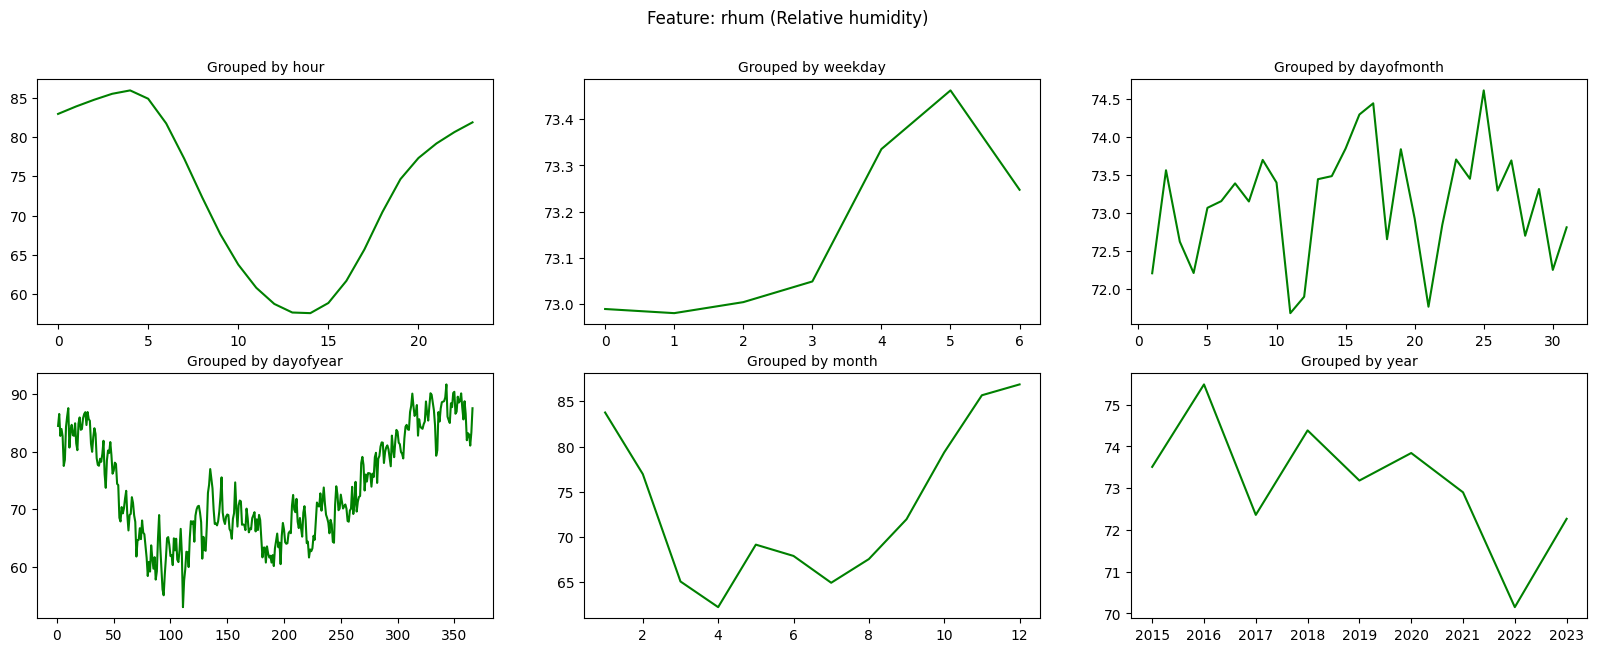

In [8]:
plot_feature(df, group_by, 'rhum', 'Relative humidity', 'green')

#### Global radiation

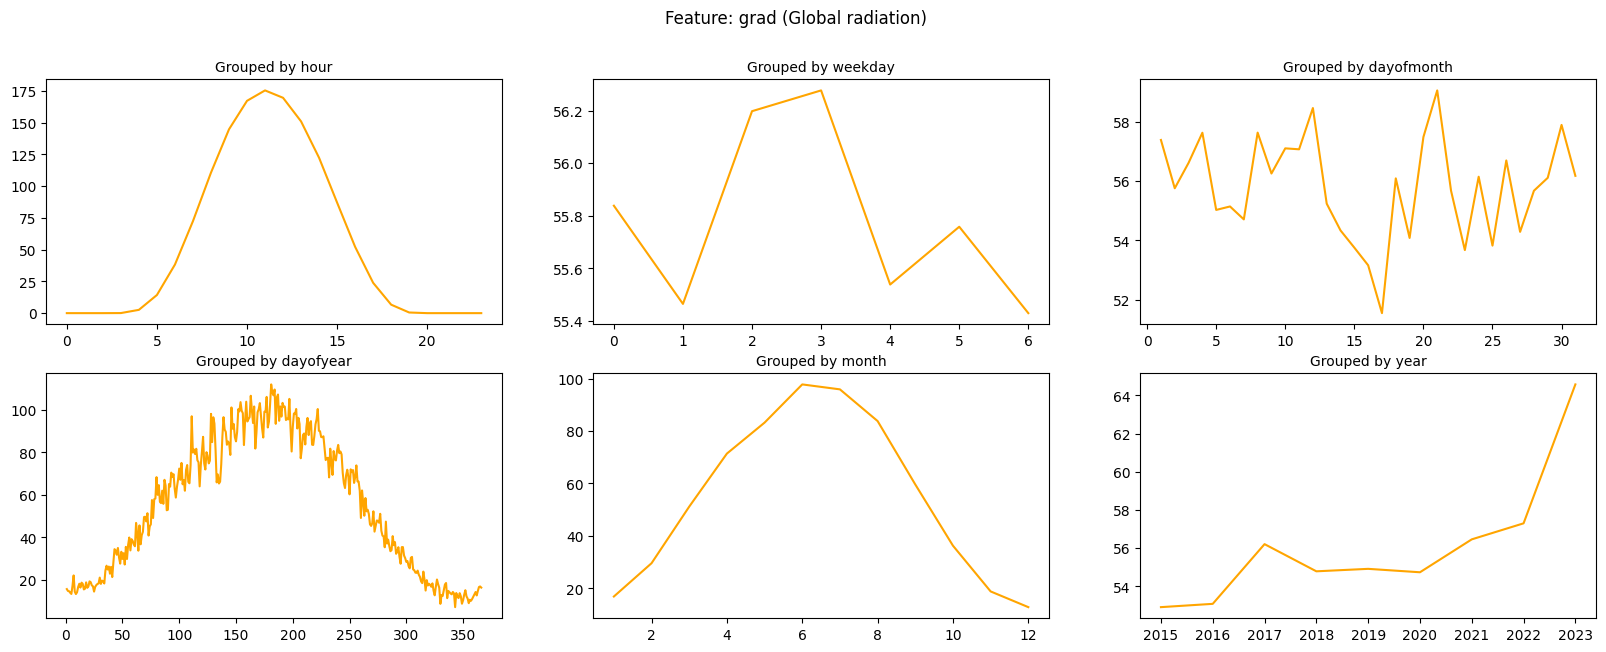

In [9]:
plot_feature(df, group_by, 'grad', 'Global radiation', 'orange')

#### Momentary sea level air pressure

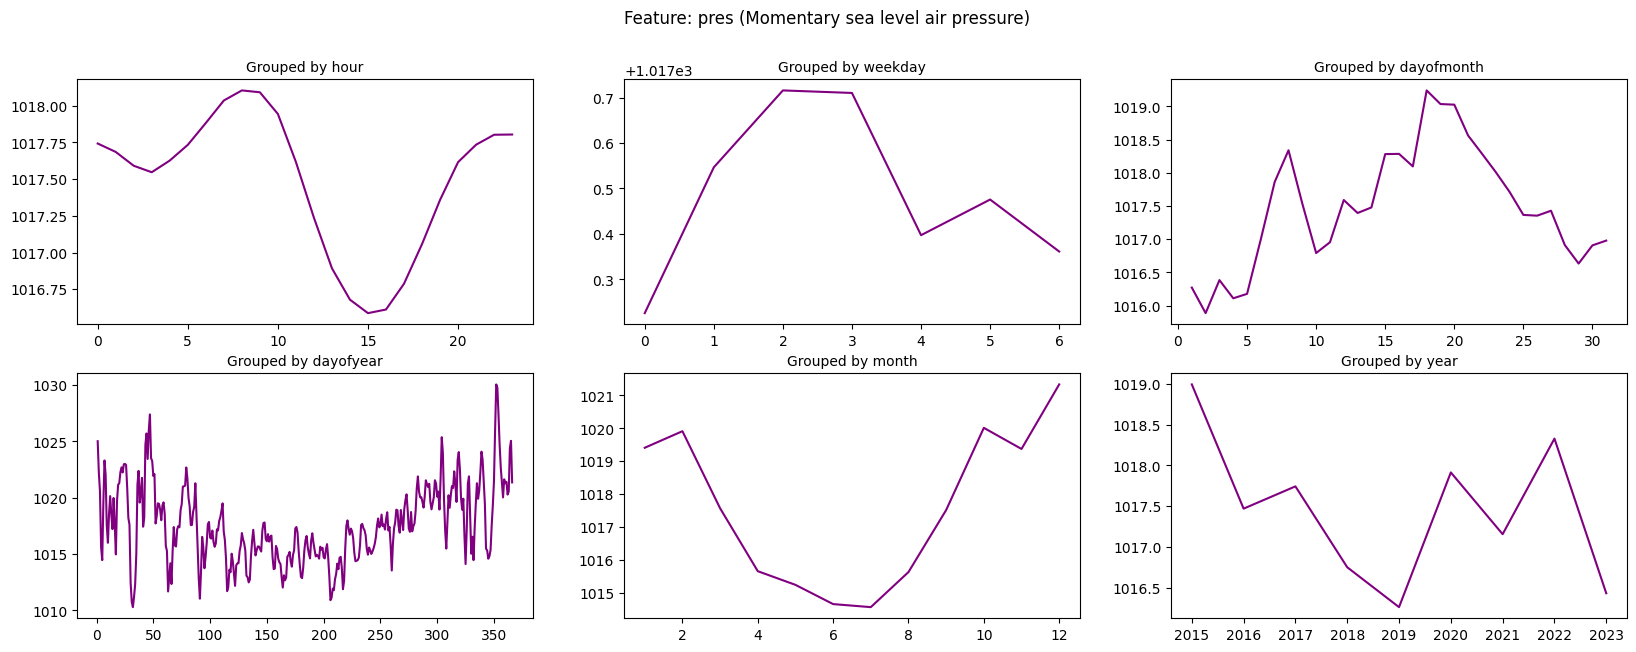

In [10]:
plot_feature(df, group_by, 'pres', 'Momentary sea level air pressure', 'purple')

#### Average wind speed

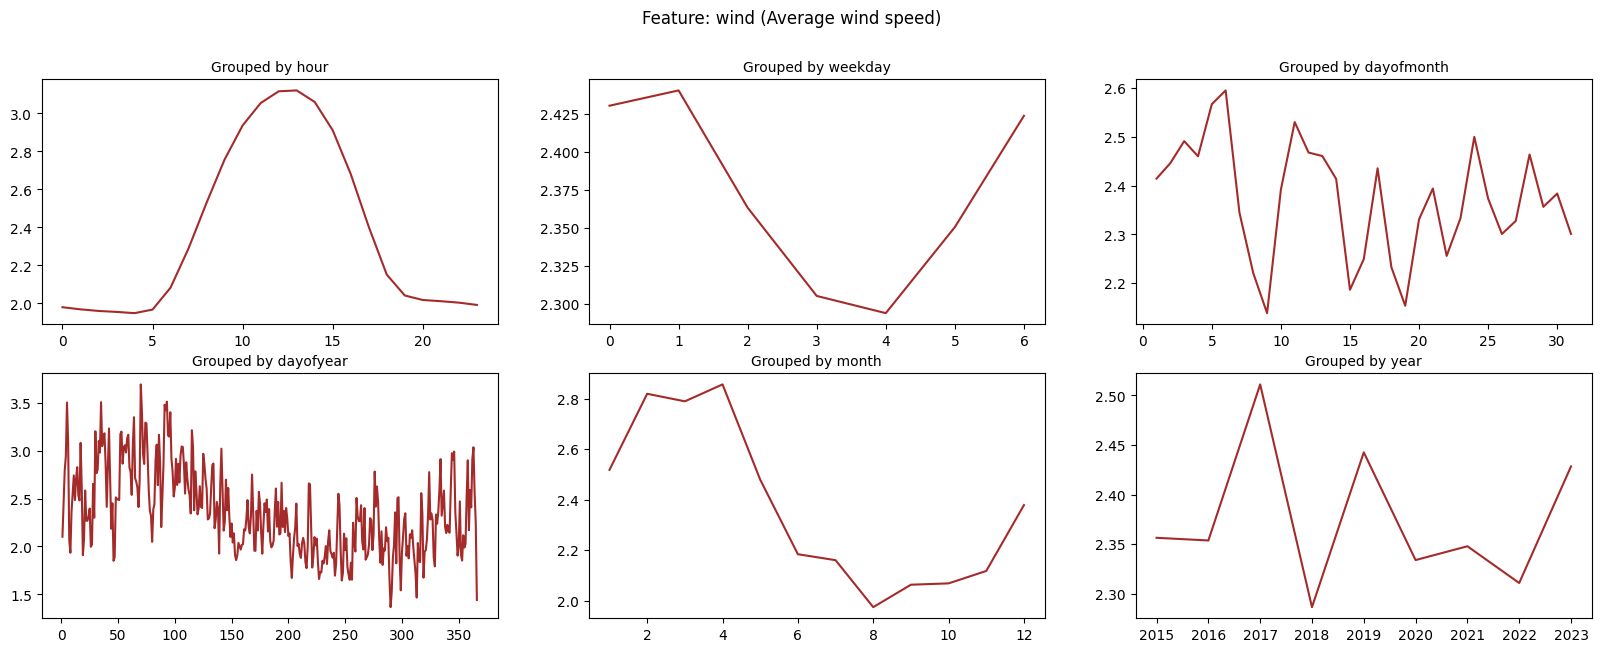

In [11]:
plot_feature(df, group_by, 'wind', 'Average wind speed', 'brown')

#### Velence water temperature in Agárd

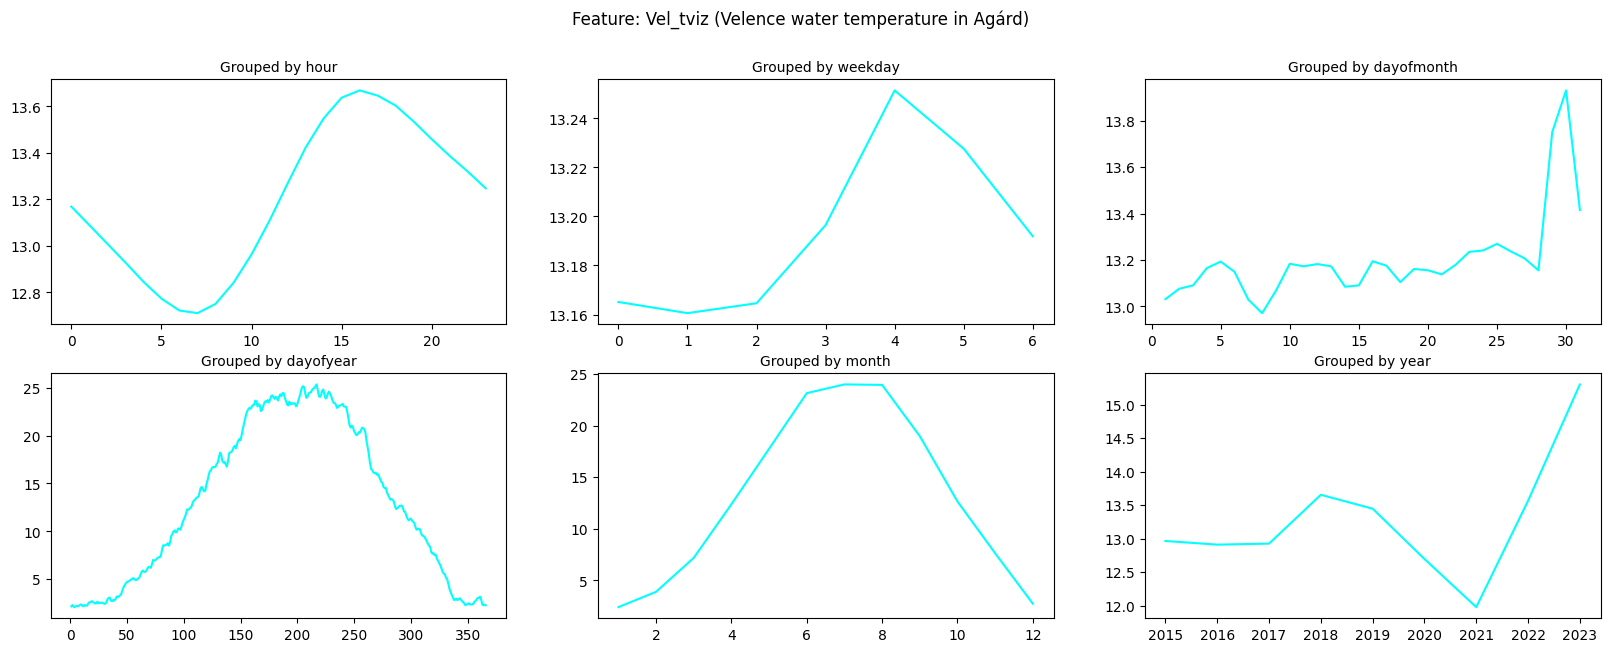

In [12]:
plot_feature(df, group_by, 'Vel_tviz', 'Velence water temperature in Agárd', 'cyan')

#### Balaton water temperature in Siófok

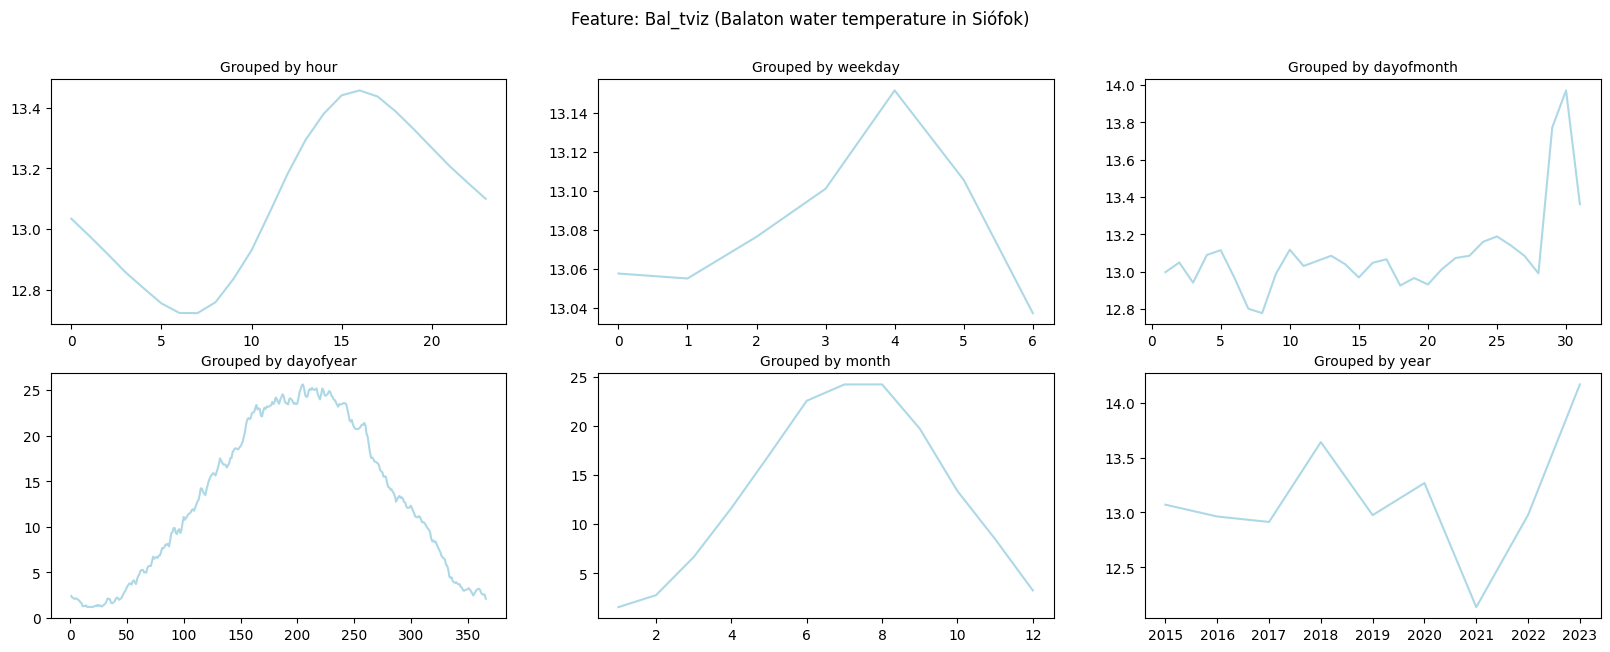

In [13]:
plot_feature(df, group_by, 'Bal_tviz', 'Balaton water temperature in Siófok', 'lightblue')